The concepts to be introduced in this notebook, such as the Ising model, simulated annealing, and the transverse Ising model, play an important role in today's quantum algorithms and quantum computing paradigms, including quantum annealing, the quantum approximate optimization algorithm, and quantum-enhanced sampling. Here we give some insight on how these physical building blocks work.

# The Ising model

We would like to make a connection between the computational hardness of a problem and how difficult it is to solve a corresponding physical system. The Ising model is the most basic model to do this. It is an extensively studied model and one of the most basic examples to teach statistical mechanics and phase transitions, but we only require an elementary understanding of it.

Imagine that you have two magnets fixed on the same axis.

<img src="../figures/two_magnets.svg" alt="Two magnets" style="width: 100px;"/>

They will naturally anti-align: one will have north pole facing up, the second the south pole facing up. We can think of them as two binary variables, $\sigma_1$ and $\sigma_2$. Say, if the north pole is facing up, we assign the value +1 to the variable, and -1 otherwise. To abstract away from magnets, in general, we call these variables spins. So in the optimal configuration, their product is -1:

$$ \sigma_1\sigma_2=-1 $$

We can think of this as the energy of the system: the lowest energy is called the ground state energy. Note that there are two physical configurations corresponding to this optimum: $\sigma_1=+1, \sigma_2=-1$, and $\sigma_1=-1, \sigma_2=+1$.

If we keep adding more magnets to this system, we can sum up their pairwise interaction to get the total energy. The total energy of the system is called the Hamiltonian, and we will denote it by $H$. So if we have $N$ magnets arranged along a straight line, we have

$$ H=\sum_{i=1}^{N-1} \sigma_i \sigma_{i+1}$$.

We did a simplification here: we assumed that remote magnets do not interact with each other, e.g. there is no such term as $\sigma_i\sigma_{i+2}$. In general, the interactions modeled depend on the layout of the spins and assumptions about the physical model: there will be some graph describing the connectivity of interactions. To reflect this, we write

$$ H=\sum_{<i,j>} \sigma_i \sigma_{j}$$,

where $<i,j>$ typically means nearest neighbours, but it is up to us to declare what nearest neighbours mean.

Now imagine that the distance is not the same between each pair. In other words, some pairs interact more than others. We can express this by adding a parameter that describes the interaction strength:

$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$,

where $J_{ij}$ is a real number. We added a negative sign to the Hamiltonian: this is by convention. If the spins are antiferromagnetic, that is, they behave as we would expect from magnets, then all $J_{ij}$ values would be negative. That cancels out the negative sign of the sum, so we still expect that each product $\sigma_i\sigma_j$ would give you -1 in the optimum configuration.

The model is fairly complicated by this point. Imagine that you have many spins and not all of them behave like magnets (that is, $J_{ij}$ can take both negative and positive values for different pairs). Nature still wants to find the lowest energy configuration, though. Let's take a look at how we would do it in code. Let's calculate the energy of spins on a line, given some couplings and a spin configuration:

In [2]:
def calculate_energy(J, σ):
    return -sum(J_ij*σ[i]*σ[i+1] for i, J_ij in enumerate(J))

Let's give it a fixed set of couplings and a spin configuration on three sites:

In [3]:
J = [1.0, -1.0]
σ = [+1, -1, +1]

The energy of this is

In [4]:
calculate_energy(J, σ)

-0.0

Is this the ground state? How do we know? We are interested in the minimum, but we cannot use some gradient-based method to find it, since the variables are binary, plus the optimization landscape is nonconvex. So the easiest choice is an exhaustive search of all possibilities:

In [5]:
import itertools
for σ in itertools.product(*[{+1,-1} for _ in range(3)]):
    print(calculate_energy(J, σ), σ)

-0.0 (1, 1, 1)
-2.0 (1, 1, -1)
-0.0 (1, -1, 1)
2.0 (1, -1, -1)
2.0 (-1, 1, 1)
-0.0 (-1, 1, -1)
-2.0 (-1, -1, 1)
-0.0 (-1, -1, -1)


We see that -2 is the optimum, with two optimal configurations, but we had to enumerate all possibilities to figure this out. For this particular case, there are more clever ways to find the best solution, but in the general case, this is not the case.

To get to the general case, we need one more component, an external field. Imagine that you add a large magnet below each and every one of our magnets, creating an external magnetic field for each site. If this field is strong enough, it can override the pairwise interaction and flip the magnets. We model this by adding a linear term to the Hamiltonian:

$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j} - \sum_i h_i \sigma_i$$,

where $h_i$ is the strength of the external field. This is the full description of the *classical Ising model*. The Hamiltonian describes the energy, but in computer science language, it means it expresses the objective function we want to minimize. The corresponding computer science problem is called quadratic unconstrained binary optimization (QUBO), where the only difference is that the variables take values in $\{0, 1\}$, but that is only a constant shift. QUBOs are NP-hard in general, that is, we are not aware of an efficient polynomial time algorithm to solve any given QUBO. So the generic strategy is the exhaustive search we did above, which takes exponentially many steps in the number of sites (variables).

As we mentioned, nature seeks the minimum energy configuration. So how does computational hardness map to physical difficulty? Imagine that the energy difference between the ground state and the next lowest energy state (also called the first excited state) is small, but the energetic cost of going from one to the other is high. A cartoon picture of this is the following:

<img src="../figures/energy_landscape.svg" alt="Energy landscape" style="width: 200px;"/>

If we start from a random configuration, we might get stuck in the local optimum denoted by the green spot. This is what happens in metals if they are cooled down too quickly: the crystal lattice will have imperfections and the metal will not have the desired properties. A process called *annealing* helps in metallurgy: by increasing the temperature, the chance of overcoming the potential barrier increases and the crystal structure can reconfigure itself. If the barrier is high and the energy difference is small between the ground state and the first excited state, the probability of this happening drops. This is what it means that the problem is difficult to do in a physical system.

Annealing inspired a heuristic algorithm called *simulated annealing*. This defines a temperature to be able to hop out of local minima. The temperature is lowered over time to find the actual minimum. Simulated annealing has many implementations. Here we'll use the one implemented in dimod to solve our problem above:

In [6]:
import dimod

The simulated annealing solver requires us to define the couplings as a dictionary between spins, and we must also pass the external field values as a dictionary. The latter is all zeros for us.

In [7]:
J = {(0, 1): 1.0, (1, 2): -1.0}
h = {0:0, 1:0, 2:0}

We instantiate an Ising model:

In [8]:
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)

Finally, we create a simulated annealing sampler that pulls out potentially optimal solutions, and we read out 10 possible solutions:

In [9]:
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)

You can see that this configuration is actually easy, since you get the optimal solution -2 most of the time:

In [12]:
print([solution.energy for solution in response.data()])
print([solution.energy for solution in response.data()].count(-2))

[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0]
10


Simulated annealing is a classical heuristic algorithm. Quantum annealing uses physical effects to find the global optimum of an Ising model: it uses thermal effects just like annealing in metallurgy, but it also uses quantum effects like tunneling to overcome potential barriers.

The Ising model also plays an important role in quantum-enhanced sampling, but that idea requires a better understanding of the role of temperature, which we will revisit in a subsequent notebook.

# The transverse-field Ising model

We discussed the Hamiltonian of the classical Ising model. We can write the same Hamiltonian in a quantum mechanical form. In quantum mechanics, the Hamiltonian is not a function of variables, but of operators. We will simulate what it means in a quantum circuit.

In [13]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
np.set_printoptions(precision=3, suppress=True)
backend = Aer.get_backend('statevector_simulator')
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)

The operator that replicates the effect of what we have seen in the classical case is the Pauli-Z matrix, defined as $\begin{bmatrix}1 & 0\\ 0& -1\end{bmatrix}$. Let's see what it does on the elements of the computational basis:

In [14]:
circuit.z(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print(state)

[1.+0.j 0.+0.j]


This is nothing but the $|0\rangle$ state. In other words, it does not do anything to $|0\rangle$, which can also be thought of as multiplying it by +1. Let's try it on $|1\rangle$:

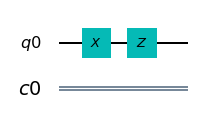

In [17]:
circuit = QuantumCircuit(q, c)
circuit.x(q[0])
circuit.z(q[0])
circuit.draw(output='mpl')

In [18]:
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print(state)

[ 0.+0.j -1.+0.j]


We get $-|1\rangle$, which means it adds a minus sign to it. This way we have the +1, -1 values, just the same way as in the classical formalism. If we write $\sigma^Z_i$ for the operator $Z$ at a site $i$, the quantum mechanical Hamiltonian of the classical Ising model reads as

$$ H=-\sum_{<i,j>} J_{ij} \sigma^Z_i \sigma^Z_{j} - \sum_i h_i \sigma^Z_i$$.

Technically speaking, we should put a hat on $H$ and on all of the $\sigma^Z_i$ to indicate that they are operators, and not numbers or variables, but we omit this for notational simplicity.

The expectation value $<H>$ of the Hamiltonian is the energy of the system, and the corresponding quantum state $|\psi\rangle$ is the configuration of that energy level. We can create the quantum mechanical version of calculating the energy, matching the function we defined above for the classical mechanical variant:

In [19]:
def calculate_energy_expectation(state, hamiltonian):
    return float((state.T.conj() @ hamiltonian @ state).real)

It is a bit tricky to define the Hamiltonian with the $\sigma^Z_i$ operators, since saying that it acts on site $i$ means that it acts trivially on all other sites. So, for instance, for two sites, if we act on site one, the actual operator is $\sigma^Z\otimes I$, and acting on site two, we have $I \otimes \sigma^Z$. The above function to calculate the energy takes numpy arrays, so we manually define $\sigma^Z$ and calculate the energy of the Hamiltonian $H=-\sigma^Z_1\sigma^Z_2  - 0.5 (\sigma^Z_1 + \sigma^Z_2)$ on the state $|00\rangle$.

In [23]:
PauliZ = np.array([[1, 0], [0, -1]])
IZ = np.kron(np.eye(2), PauliZ)
ZI = np.kron(PauliZ, np.eye(2))
ZZ = np.kron(PauliZ, PauliZ)
print("IZ\n", IZ)
H = -ZZ + -0.5*(ZI+IZ)
ψ = np.kron([[1], [0]], [[1], [0]])
calculate_energy_expectation(ψ, H)

IZ
 [[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0.  1.  0.]
 [ 0. -0.  0. -1.]]


-2.0

This Hamiltonian commutes, which means all of its operators are commutative, which is a clear sign of nothing much quantum going on.

To make this a quantum Ising model, we need to add a term that does not commute with the rest of the terms. A transverse field is such, which is an on-site interaction just like the external field. Its effect is described by the Pauli-X operator (the NOT gate), which we will denote by $\sigma^X_i$ for a site $i$. It is very easy to see that the Pauli-Z and the Pauli-X do not commute:

In [24]:
circuit = QuantumCircuit(q, c)
circuit.x(q[0])
circuit.z(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print("Pauli-X, then Pauli-Z:", state)
circuit = QuantumCircuit(q, c)
circuit.z(q[0])
circuit.x(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print("Pauli-Z, then Pauli-X:", state)

Pauli-X, then Pauli-Z: [ 0.+0.j -1.+0.j]
Pauli-Z, then Pauli-X: [0.+0.j 1.+0.j]


There is a clear sign difference.

There are many other ways of making the Ising Hamiltonian noncommuting, but adding the onsite Pauli-X operations leads to the *transverse field Ising model*. Its Hamiltonian reads as

$$ H=-\sum_{<i,j>} J_{ij} \sigma^Z_i \sigma^Z_{j} - \sum_i h_i \sigma^Z_i - \sum_i g_i \sigma^X_i$$.

The transverse field Ising model is critically important to explain how quantum annealing works because by adding the $\sigma^X$ part to the Hamiltonian it becomes possible to exploit quantum effects like tunnelling. It is also important for understanding the quantum approximation optimization algorithms, since it was inspired by quantum annealing.